## Imports

In [1]:
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

#### Styles

In [2]:
plt.style.use("ggplot")

## Data loading

In [3]:
def create_df(path: str):
    with open(path) as f:
        data = json.load(f)

    d = {"match_id": [], "tier": [], "team": [], "participant_puuid": [], "previous_matches": []}
    for match_infos in data:
        for team_100_infos in match_infos["team_100"]:
            d["match_id"].append(match_infos["match_id"])
            d["tier"].append(match_infos["tier"])
            d["team"].append("team_100")
            d["participant_puuid"].append(team_100_infos["participant_puuid"])
            d["previous_matches"].append(team_100_infos["previous_matches"])

        for team_200_infos in match_infos["team_200"]:
            d["match_id"].append(match_infos["match_id"])
            d["tier"].append(match_infos["tier"])
            d["team"].append("team_200")
            d["participant_puuid"].append(team_200_infos["participant_puuid"])
            d["previous_matches"].append(team_200_infos["previous_matches"])
    
    return pd.DataFrame(d)

In [4]:
df1 = create_df("data/data_CHALLENGER_194_1676362154.json")
df2 = create_df("data/data_GRANDMASTER_255_1676435692.json")
df3 = create_df("data/data_MASTER_270_1676513097.json")
df4 = create_df("data/data_DIAMOND_444_1676712036.json")

In [5]:
df = pd.concat([df1, df2, df3, df4])

In [6]:
duplicated = df.loc[:, ["match_id", "participant_puuid"]].duplicated(keep="first")
df_no_duplicates = df.loc[~duplicated, :].copy()

In [7]:
df_no_duplicates["tier"] = df_no_duplicates.tier.apply(lambda x: "MASTER+" if x in ["CHALLENGER", "GRANDMASTER", "MASTER"] else x)

In [8]:
number_matches = len(df_no_duplicates.match_id.unique())
print(f"Unique matches : {number_matches}")
print(f"Unique Teams : {number_matches*2}")

Unique matches : 1139
Unique Teams : 2278


In [9]:
# Distribution of matches by tier
df_no_duplicates.loc[:, ["tier", "match_id"]].value_counts().groupby("tier").count()

tier
DIAMOND    444
MASTER+    695
dtype: int64

## Statistics

In [10]:
def create_df_with_statitic(df, apply_func):
    df = df.copy()
    df["stat_value"] = df.previous_matches.apply(apply_func)
    
    match_not_to_be_count = df.loc[df.stat_value.isna(), "match_id"].unique()
    new_df = df.loc[~df.match_id.isin(match_not_to_be_count), :]
    df_stat = new_df.loc[:, ["match_id", "team", "stat_value", "tier"]].groupby(["match_id", "team", "tier"], as_index=False).mean()
    
    return df_stat

In [43]:
def create_plot(df, title, xlabel, categories = False):
    
    if categories is False:
        fig, ax = plt.subplots(figsize=(20,10))

        sns.kdeplot(data=df, x="stat_value", ax=ax, fill=True, cut=0, label="All tiers")
    
    else:
        categories = df.tier.unique()
        
        fig, ax = plt.subplots(figsize=(20,10))
        
        for categorie in categories:
            sns.kdeplot(data=df.loc[df.tier == categorie, :], x="stat_value", ax=ax, fill=True, cut=0, label=f"{categorie} tier")
            
        
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")

    plt.show()

In [12]:
def print_stats(df, categories = False):
    if categories == False:
        print("GLOBAL INFORMATION ON STAT")
        print(f"Average : {df.stat_value.mean():.3}")
        print(f"Median : {df.stat_value.median():.3}")
        print(f"Max. : {df.stat_value.max():.3}")
        print(f"Min. : {df.stat_value.min():.3}")
        print(f"Variance : {df.stat_value.var():.3}")
    
    else:
        categories = df.tier.unique()
        for categorie in categories:
            print(f"INFORMATION ABOUT THE STAT OF THE TIER : '{categorie}'")
            print(f"Average : {df.loc[df.tier == categorie, :].stat_value.mean():.3}")
            print(f"Median : {df.loc[df.tier == categorie, :].stat_value.median():.3}")
            print(f"Max. : {df.loc[df.tier == categorie, :].stat_value.max():.3}")
            print(f"Min. : {df.loc[df.tier == categorie, :].stat_value.min():.3}")
            print(f"Variance : {df.loc[df.tier == categorie, :].stat_value.var():.3}")
            print("---------------")

### 1. The number of defeats in a row

In [13]:
def apply_number_of_defeats_in_a_row(x):
    count = 0
    for d in x:
        if d["result"] == "victory":
            return count
        count += 1

In [14]:
df_number_of_defeats_in_a_row = create_df_with_statitic(df_no_duplicates, apply_number_of_defeats_in_a_row)

In [15]:
print(f"Number of teams : {df_number_of_defeats_in_a_row.shape[0]}")

Number of teams : 2074


In [16]:
# Distribution of teams by tier
df_number_of_defeats_in_a_row.tier.value_counts()

MASTER+    1342
DIAMOND     732
Name: tier, dtype: int64

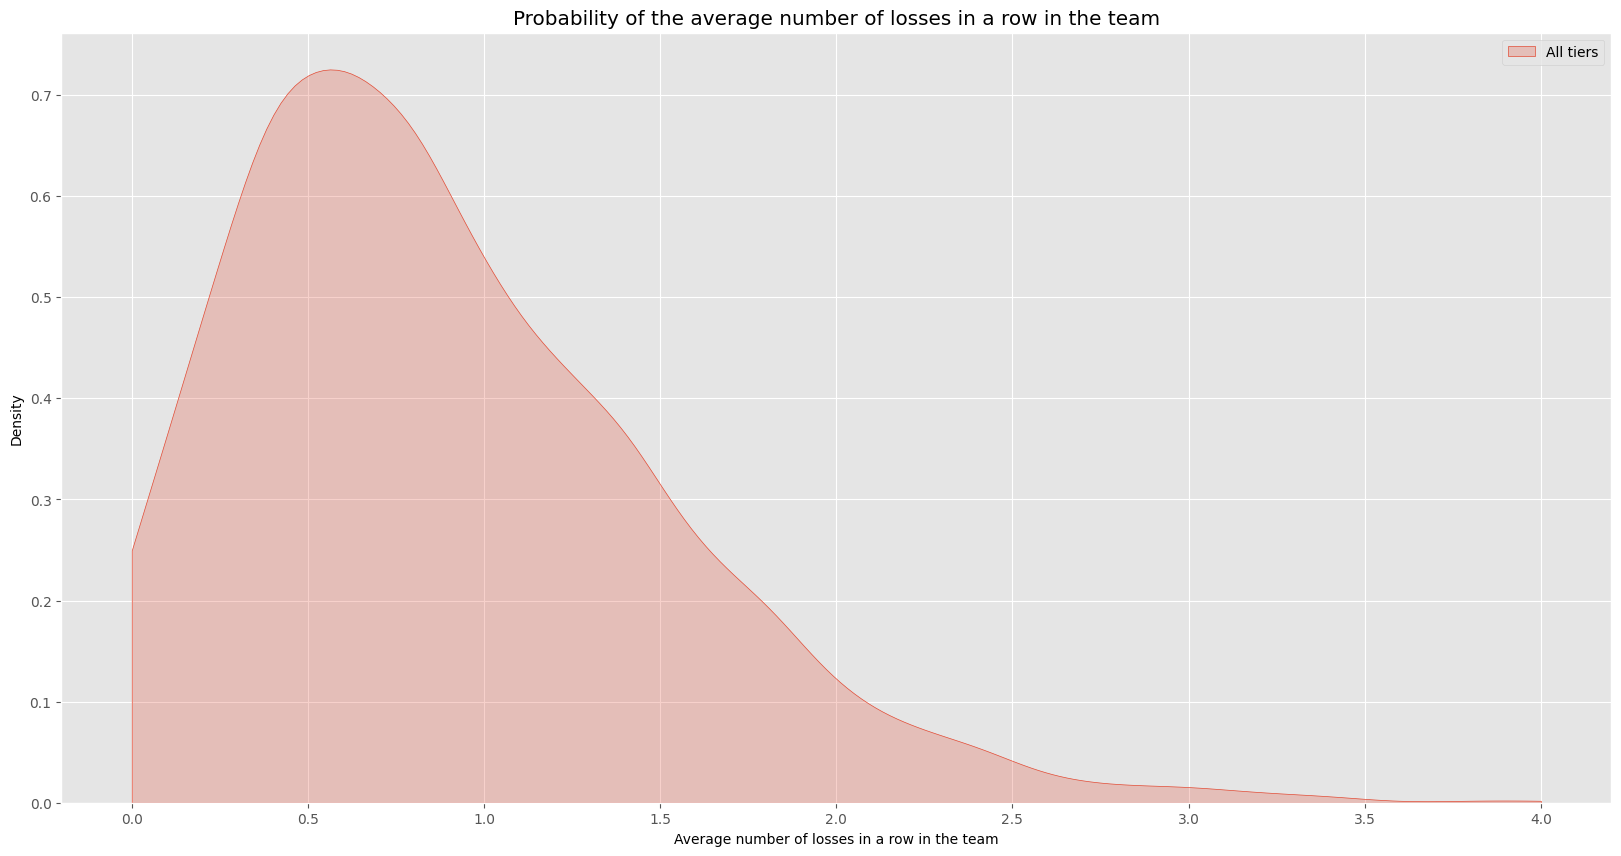

GLOBAL INFORMATION ON STAT
Average : 0.897
Median : 0.8
Max. : 4.0
Min. : 0.0
Variance : 0.372


In [44]:
create_plot(df=df_number_of_defeats_in_a_row,
            title="Probability of the average number of losses in a row in the team",
            xlabel="Average number of losses in a row in the team")

print_stats(df=df_number_of_defeats_in_a_row)

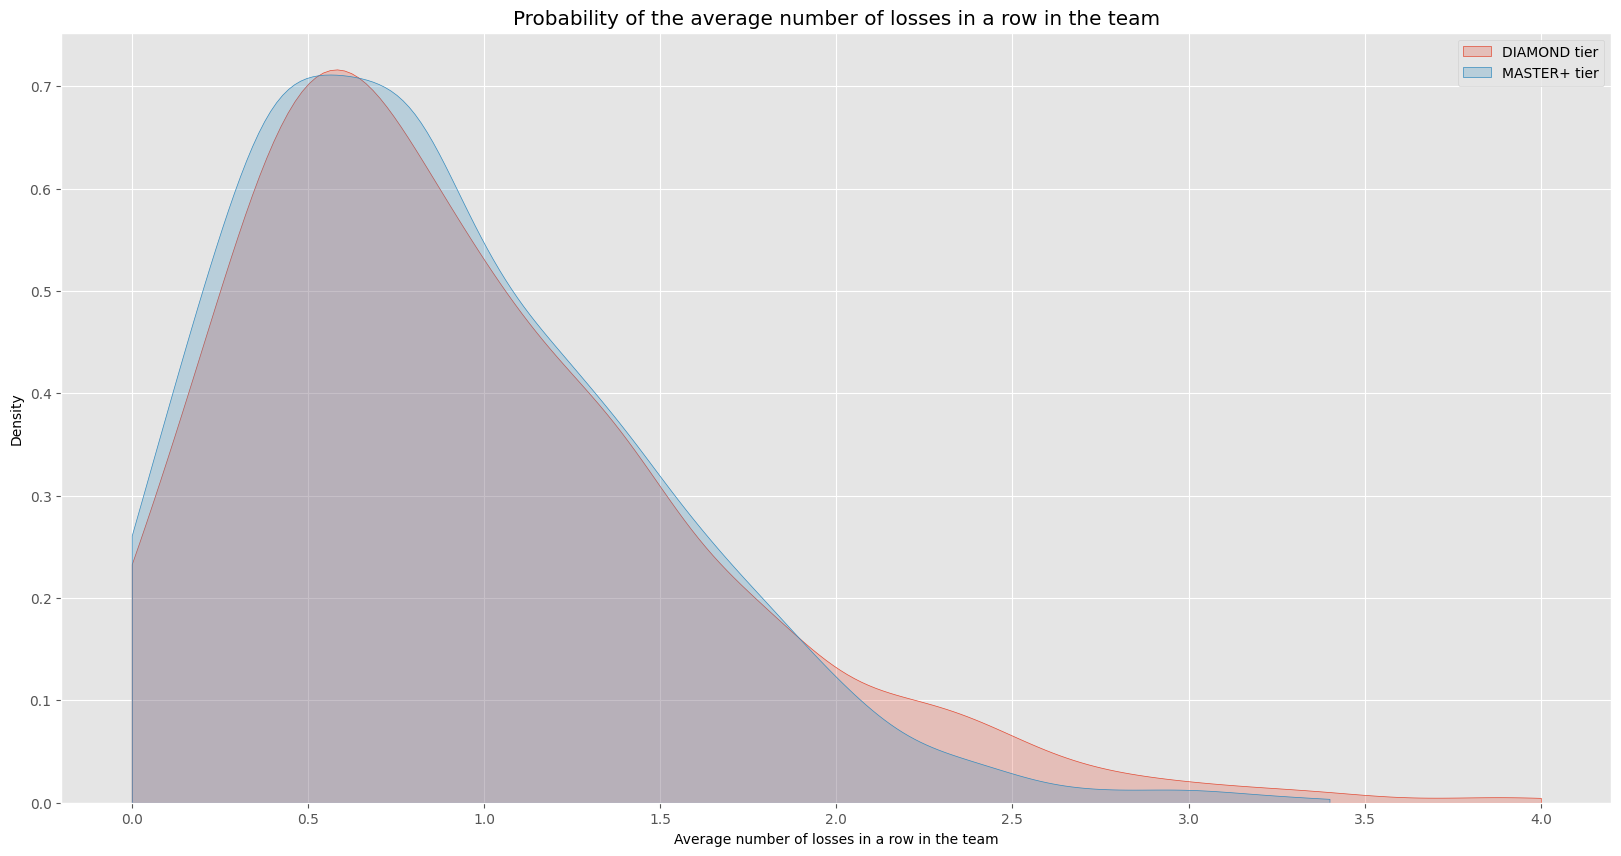

INFORMATION ABOUT THE STAT OF THE TIER : 'DIAMOND'
Average : 0.941
Median : 0.8
Max. : 4.0
Min. : 0.0
Variance : 0.432
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'MASTER+'
Average : 0.873
Median : 0.8
Max. : 3.4
Min. : 0.0
Variance : 0.337
---------------


In [45]:
create_plot(df=df_number_of_defeats_in_a_row,
            title="Probability of the average number of losses in a row in the team",
            xlabel="Average number of losses in a row in the team",
            categories=True)

print_stats(df=df_number_of_defeats_in_a_row, categories=True)

### 2. The sum of losses in the last 10 games

In [19]:
def apply_sum_of_losses_in_the_last_10_games(x):
    if len(x) < 10:
        return np.nan
    
    count = 0
    for d in x[0:10]:
        if d["result"] == "defeat":
            count += 1
    
    return count

In [20]:
df_sum_of_losses_in_the_last_10_games = create_df_with_statitic(df_no_duplicates, apply_sum_of_losses_in_the_last_10_games)

In [21]:
print(f"Number of teams : {df_sum_of_losses_in_the_last_10_games.shape[0]}")

Number of teams : 2032


In [22]:
# Distribution of teams by tier
df_sum_of_losses_in_the_last_10_games.tier.value_counts()

MASTER+    1332
DIAMOND     700
Name: tier, dtype: int64

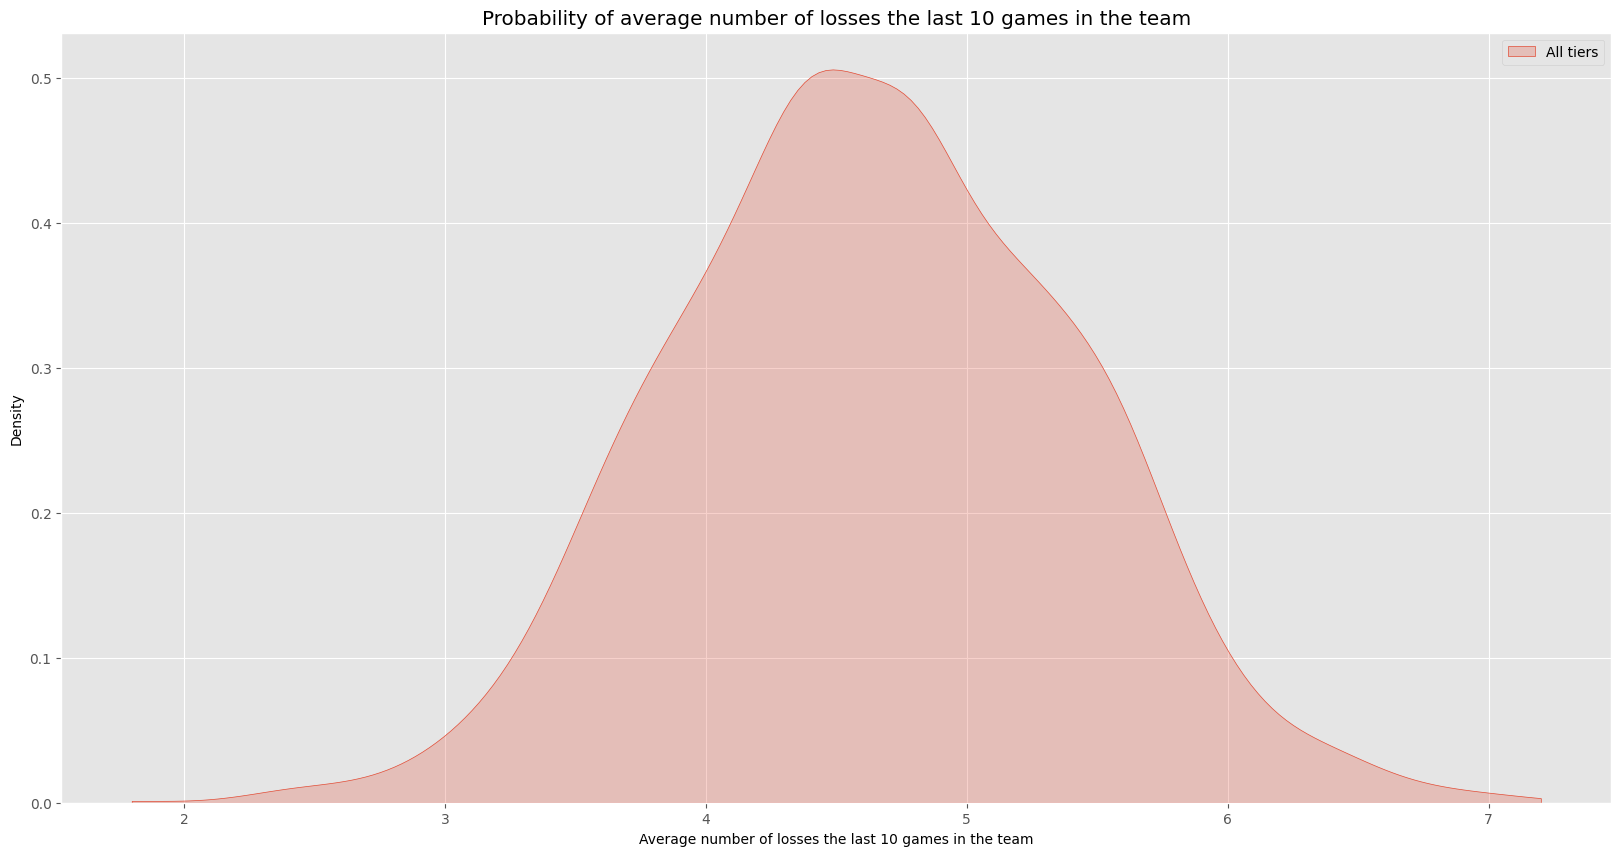

GLOBAL INFORMATION ON STAT
Average : 4.64
Median : 4.6
Max. : 7.2
Min. : 1.8
Variance : 0.583


In [46]:
create_plot(df=df_sum_of_losses_in_the_last_10_games,
            title="Probability of average number of losses the last 10 games in the team",
            xlabel="Average number of losses the last 10 games in the team")

print_stats(df=df_sum_of_losses_in_the_last_10_games)

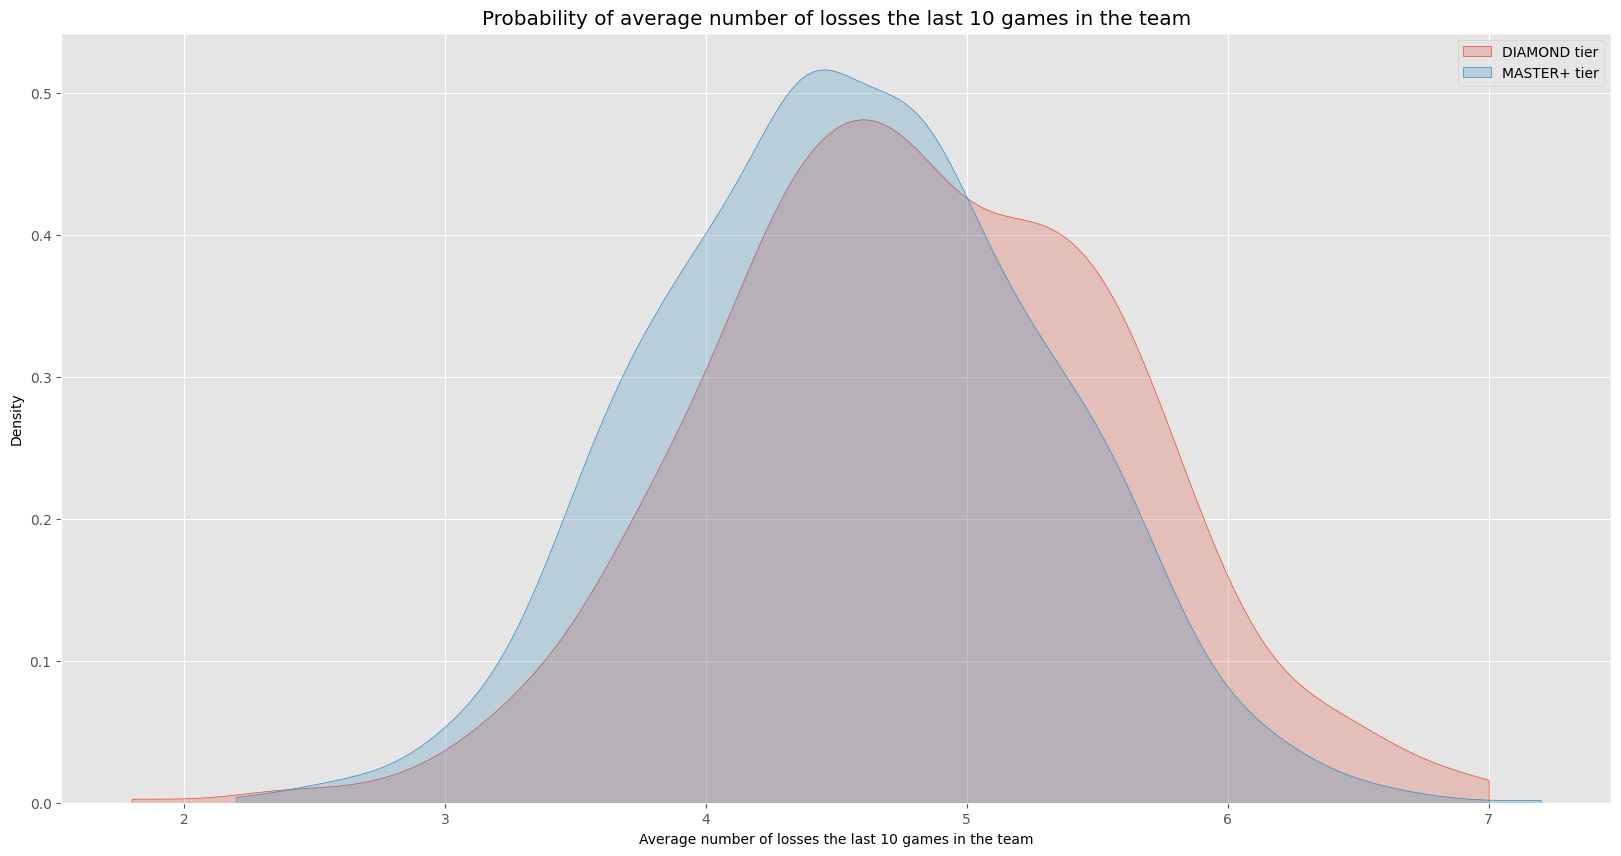

INFORMATION ABOUT THE STAT OF THE TIER : 'DIAMOND'
Average : 4.8
Median : 4.8
Max. : 7.0
Min. : 1.8
Variance : 0.628
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'MASTER+'
Average : 4.56
Median : 4.6
Max. : 7.2
Min. : 2.2
Variance : 0.539
---------------


In [47]:
create_plot(df=df_sum_of_losses_in_the_last_10_games,
            title="Probability of average number of losses the last 10 games in the team",
            xlabel="Average number of losses the last 10 games in the team",
            categories=True)

print_stats(df=df_sum_of_losses_in_the_last_10_games, categories=True)